### Cryosat Level-2 altimetry data visualization.
#### Data search and download: 
#### 1) from: https://visioterra.net/VtCryoSat/; this way can only download the level-2 data product.
#### 2) from: https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-CryoSat.products%22:%22%22,%22commonCriteria%22:%22bbox=-180,-90,180,90%22}
#### Note: the ftp account: Username: <u>anonymous</u>; Password: <u>your email address</u>


In [9]:
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import h5py
import numpy as np
from utils.geotif_io import readTiff
from utils.imgShow import imgShow


### The data (path_cryo2_gopm_1b and path_cryo2_gopm_2) downloaded from (2) could not be read by xarray module.


In [2]:
## s3 data
path_cryo2_gopm_1b = 'data/cryosat-2/CS_LTA__SIR_GOPM1B_20161030T001715_20161030T001812_C001.nc'
path_cryo2_gopm_2 = 'data/cryosat-2/CS_LTA__SIR_GOPM_2_20161030T001715_20161030T001812_C001.nc'
path_cryo2_gop_2 = 'data/cryosat-2/CS_LTA__SIR_GOP_2__20161029T234613_20161030T003549_C001.nc'
## remote sensing data
path_rsimg = 'data/rs-img/dianchi_s2_20200511_wgs84.tif'
path_rsimg_wat = 'data/water_mask/dianchi_s2_20200511_wat_wgs84.tif'


### Data reading

In [10]:
## 1. s3l2 altimetry data
cryo2_gop_2 = xr.open_dataset(path_cryo2_gop_2)
cryo2_gopm_2 = nc.Dataset(path_cryo2_gopm_2)  ## some problems occurs when use xarry for reading.
cryo2_gopm_1b = nc.Dataset(path_cryo2_gopm_1b)
## 2. remote sensing image
rs_img, rs_img_info = readTiff(path_rsimg)
rs_wat, rs_wat_info = readTiff(path_rsimg_wat)


In [29]:
cryo2_gopm_1b.variables.keys()


odict_keys(['agc_01_ku', 'agc_20_ku', 'agc_cor_01', 'alt_01', 'alt_20_ku', 'cog_cor_01', 'cor2_applied_20_ku', 'dop_cor_01_ku', 'dop_cor_20_ku', 'echo_numval_20_ku', 'echo_scale_20_ku', 'flag_cor_err_01', 'flag_cor_status_01', 'flag_instr_conf_rx_bwdt_20_ku', 'flag_instr_conf_rx_flags_20_ku', 'flag_instr_conf_rx_in_use_20_ku', 'flag_instr_conf_rx_trk_mode_20_ku', 'flag_instr_op_mode_20_ku', 'flag_mcd_20_ku', 'flag_trk_cycle_20_ku', 'h0_applied_20_ku', 'h0_fai_word_20_ku', 'h0_lai_word_20_ku', 'hf_fluct_cor_01', 'ind_first_meas_20hz_01', 'ind_meas_1hz_20_ku', 'int_path_cor_01', 'internal_cor_sig0_01', 'inv_bar_cor_01', 'iono_cor_gim_01', 'lat_01', 'lat_20_ku', 'load_tide_sol1_01', 'load_tide_sol2_01', 'lon_01', 'lon_20_ku', 'mod_dry_tropo_cor_01', 'mod_wet_tropo_cor_01', 'noise_power_20_ku', 'ns_20_ku', 'num_meas_20hz_01', 'ocean_tide_eq_01', 'ocean_tide_non_eq_01', 'ocean_tide_sol1_01', 'ocean_tide_sol2_01', 'orb_alt_rate_01', 'orb_alt_rate_20_ku', 'pole_tide_01', 'pwr_waveform_20_ku',

In [40]:
cryo2_gopm_1b.variables['pwr_waveform_20_ku'][:].shape


(1078, 128)

In [38]:
cryo2_gopm_2.variables.keys()
# cryo2_gopm_2.variables['ssha_20_ku'][600:]


odict_keys(['agc_01_ku', 'agc_cor_01', 'alt_01', 'alt_20_ku', 'alt_20_plrm_ku', 'atm_cor_sig0_01', 'cog_cor_01', 'dop_cor_01_ku', 'flag_instr_op_mode_01', 'flag_instr_op_mode_20_ku', 'flag_instr_op_mode_20_plrm_ku', 'flag_mcd_20_ku', 'geoid_01', 'gpd_wet_tropo_cor_01', 'gpd_wet_tropo_cor_qual_01', 'hf_fluct_cor_01', 'ind_first_meas_20hz_01', 'ind_first_meas_20hz_01_plrm_ku', 'ind_meas_1hz_20_ku', 'ind_meas_1hz_20_plrm_ku', 'int_path_cor_01', 'internal_cor_sig0_01', 'inv_bar_cor_01', 'iono_cor_gim_01', 'lat_01', 'lat_20_ku', 'lat_20_plrm_ku', 'load_tide_sol1_01', 'load_tide_sol2_01', 'lon_01', 'lon_20_ku', 'lon_20_plrm_ku', 'mean_dyn_topo_sol1_01', 'mean_dyn_topo_sol2_01', 'mean_sea_surf_sol1_01', 'mean_sea_surf_sol2_01', 'mod_dry_tropo_cor_01', 'mod_instr_cor_range_01_ku', 'mod_instr_cor_range_01_plrm_ku', 'mod_instr_cor_sig0_01_ku', 'mod_instr_cor_sig0_01_plrm_ku', 'mod_instr_cor_swh_01_ku', 'mod_instr_cor_swh_01_plrm_ku', 'mod_wet_tropo_cor_01', 'mqe_ocean_20_ku', 'mqe_ocean_20_plrm_

### Visualization from global perspective

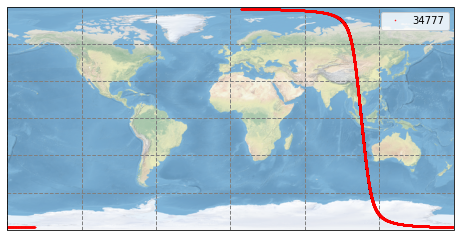

In [6]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=proj); ax.stock_img()
orbit = str(cryo2_gop_2.attrs['abs_orbit_number'])
ax.plot(cryo2_gop_2['lon_20_ku'], cryo2_gop_2['lat_20_ku'], marker='.', markersize=1, 
                                linewidth=0.0, label=orbit, color='red')
ax.gridlines(linewidth=1, color='gray', linestyle='--')
ax.legend()


### Visualization from local perspective

Text(0.5, 1.0, 'merged data')

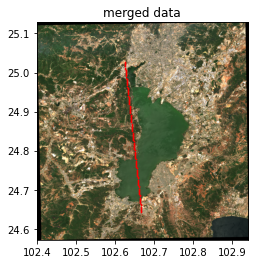

In [7]:
ids = np.where((cryo2_gop_2['lat_20_ku']>24.64) & (cryo2_gop_2['lat_20_ku']<25.03)) 
fig = plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=cryo2_gop_2['lon_20_ku'][ids], y=cryo2_gop_2['lat_20_ku'][ids], s=0.5, color='red')  ## altimetry data
plt.title('merged data')

# plt.subplot(1,3,2)
# imgShow(rs_img, extent=rs_img_info['geoextent'])
# plt.scatter(x=s3_l2_subs['lon_20_ku'], y=s3_l2_subs['lat_20_ku'], s=0.5, color='red')  ## altimetry data
# plt.title('subset data')

# plt.subplot(1, 3, 3)
# imgShow(rs_wat, extent=rs_wat_info['geoextent'])
# plt.title('Surface water map')

